# Mapping Coastal Water Quality Transect Data with Cartopy
I've been using Python's matplotlib basemap library for static maps for the past six-ish years but have been meaning to transition to cartopy ever since I saw basemap's [deprecation notice](https://matplotlib.org/basemap/#deprecation-notice) a few years ago. But I had a hard time figuring out what my options for basemap (using "basemap" in the generic sense, meaning the visual map on which data will be plotted, AKA "tiles" using webmap lingo) layers were in cartopy. If you're good at reading APIs, you probably don't need this example, and should instead just go to the source: https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/io/img_tiles.html. 

Here is some code that plots geolocated water quality sensor data on a cartopy basemap using Mapbox examples.

## Technical details
- I'm using cartopy 0.20.3: https://scitools.org.uk/cartopy/docs/latest/citation.html
- Here's cartopy's example for using the Stamen tiles: https://github.com/SciTools/cartopy/blob/main/examples/web_services/image_tiles.py. 
- I store my Mapbox key locally and I source it as a variable in my main environment (i.e., every time I open Terminal running zsh on my MacBook) rather than hard-coding it in this notebook. 
- Lots of other options for basemaps. See Map subheading for more.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
import pytz
pacific = pytz.timezone('US/Pacific')

plt.close('all')

mapbox_access_token = os.environ['MY_MAPBOX_KEY']

In [3]:
fname = 'EXO2 7-5 Summer Ventures sans metadata.csv'
fpath = os.path.join('Data', fname)

# df_full = pd.read_csv('Data/EXO2 data copied from Kor without headers - 071322 135218.csv', parse_dates=[0,1]) # Smith Creek kayak
df_full = pd.read_csv(fpath, parse_dates=[0,1]) # Carolina Runner/Banks Channel

df_full.head()

,Date (MM/DD/YYYY),Time (HH:mm:ss),Time (Fract. Sec),Site Name,Chlorophyll RFU,Cond µS/cm,Depth m,fDOM QSU,fDOM RFU,nLF Cond µS/cm,...,pH,pH mV,Temp °C,Vertical Position m,GPS Latitude °,GPS Longitude °,Altitude m,Battery V,Cable Pwr V,Barometer mmHg
0,2023-07-05,2023-07-05 09:51:24,0,<None>,1.13,51808.2,0.300,18.71,6.24,48339.7,...,7.94,-55.9,28.365,0.290,34.15606,-77.85645,-0.1,0,12,762.5
1,2023-07-05,2023-07-05 09:51:25,0,<None>,1.14,51807.9,0.301,18.76,6.25,48342.2,...,7.94,-55.9,28.362,0.301,34.15606,-77.85645,-0.2,0,12,762.5
2,2023-07-05,2023-07-05 09:51:26,0,<None>,1.14,51809.2,0.301,18.82,6.27,48345.6,...,7.94,-55.8,28.360,0.291,34.15606,-77.85645,-0.4,0,12,762.6
3,2023-07-05,2023-07-05 09:51:27,0,<None>,1.15,51814.6,0.302,18.79,6.26,48353.6,...,7.93,-55.8,28.356,0.289,34.15606,-77.85645,-0.3,0,12,762.5
4,2023-07-05,2023-07-05 09:51:28,0,<None>,1.52,51820.6,0.303,18.78,6.26,48364.6,...,7.93,-55.8,28.351,0.295,34.15606,-77.85645,-0.1,0,12,762.5


## Column headers
Pull from these columns when choosing what to plot below

In [4]:
df_full.columns

Index(['Date (MM/DD/YYYY)', 'Time (HH:mm:ss)', 'Time (Fract. Sec)',
       'Site Name', 'Chlorophyll RFU', 'Cond µS/cm', 'Depth m', 'fDOM QSU',
       'fDOM RFU', 'nLF Cond µS/cm', 'ODO % sat', 'ODO % CB', 'ODO mg/L',
       'Pressure psi a', 'Sal psu', 'SpCond µS/cm', 'TAL PE RFU', 'TDS mg/L',
       'Turbidity FNU', 'TSS mg/L', 'pH', 'pH mV', 'Temp °C',
       'Vertical Position m', 'GPS Latitude °', 'GPS Longitude °',
       'Altitude m', 'Battery V', 'Cable Pwr V', 'Barometer mmHg'],
      dtype='object')

## Truncation
Often necessary to remove chunks of data due to known issues (e.g., sensor out of water during this time period). Check lab notebook for rationale and equate `df_trunc` to `df_full` if no truncation necessary

In [5]:
df_trunc = df_full#[19:335]
df_trunc.head()

,Date (MM/DD/YYYY),Time (HH:mm:ss),Time (Fract. Sec),Site Name,Chlorophyll RFU,Cond µS/cm,Depth m,fDOM QSU,fDOM RFU,nLF Cond µS/cm,...,pH,pH mV,Temp °C,Vertical Position m,GPS Latitude °,GPS Longitude °,Altitude m,Battery V,Cable Pwr V,Barometer mmHg
0,2023-07-05,2023-07-05 09:51:24,0,<None>,1.13,51808.2,0.300,18.71,6.24,48339.7,...,7.94,-55.9,28.365,0.290,34.15606,-77.85645,-0.1,0,12,762.5
1,2023-07-05,2023-07-05 09:51:25,0,<None>,1.14,51807.9,0.301,18.76,6.25,48342.2,...,7.94,-55.9,28.362,0.301,34.15606,-77.85645,-0.2,0,12,762.5
2,2023-07-05,2023-07-05 09:51:26,0,<None>,1.14,51809.2,0.301,18.82,6.27,48345.6,...,7.94,-55.8,28.360,0.291,34.15606,-77.85645,-0.4,0,12,762.6
3,2023-07-05,2023-07-05 09:51:27,0,<None>,1.15,51814.6,0.302,18.79,6.26,48353.6,...,7.93,-55.8,28.356,0.289,34.15606,-77.85645,-0.3,0,12,762.5
4,2023-07-05,2023-07-05 09:51:28,0,<None>,1.52,51820.6,0.303,18.78,6.26,48364.6,...,7.93,-55.8,28.351,0.295,34.15606,-77.85645,-0.1,0,12,762.5


## Get parameters of interest and set limits

In [23]:
lat_all = df_trunc["GPS Latitude °"]
lon_all = df_trunc["GPS Longitude °"]

lat_mask = lat_all==0
lon_mask = lon_all==0

df_trunc = df_trunc[~lat_mask]
df_trunc = df_trunc[~lon_mask]

lat = df_trunc["GPS Latitude °"]
lon = df_trunc["GPS Longitude °"]

# Get desired variable
var_name = 'ODO % sat' # selected from columns above
plot_var = df_trunc[var_name]

plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16

## Time-series plot of parameter of interest

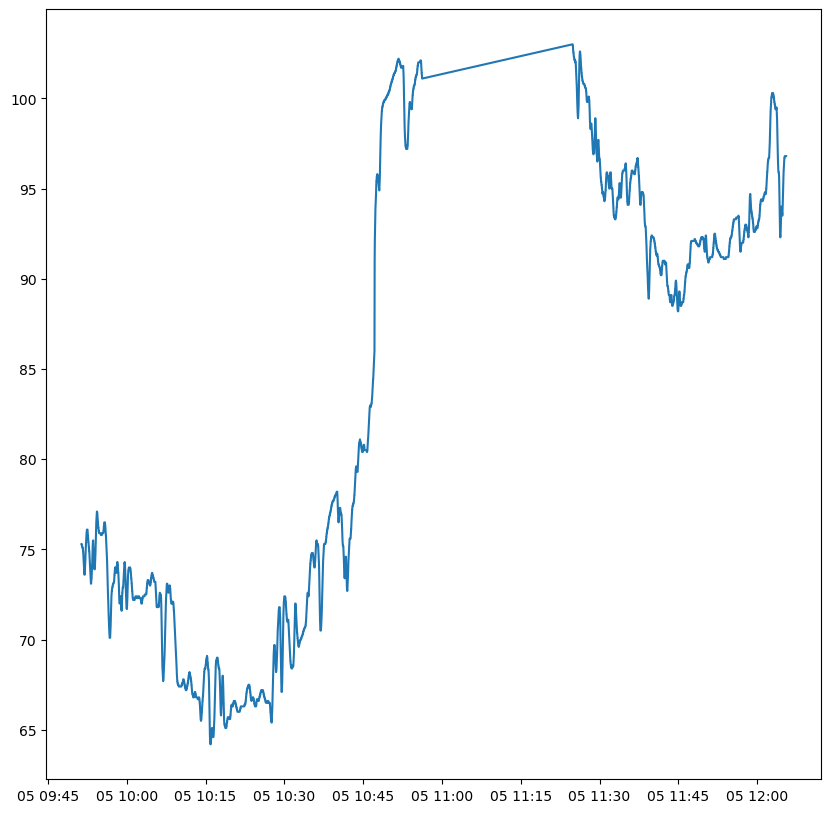

In [24]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df_trunc['Time (HH:mm:ss)'], df_trunc[var_name])

## Map of variable of interest
- Image tile options via Cartopy are currently buried in the API under cartopy.io.img_tiles described here: https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/io/img_tiles.html. Scroll down to see different options under the different classes. Change the class 
- Here are some examples of the Mapbox style offerings: https://docs.mapbox.com/api/maps/styles/. Change `map_id` to use others.
- See also https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html for formatting.

### Options
See below for several examples. Then in subsequent cell, define which choice you'd like by setting `base_layer` and `tile_zoom` to match one of these examples.

In [25]:
# Map options: (un)comment blocks corresponding to choice and check to make sure base_layer and tile_zoom are defined
## Stamen
base_layer_stamen = cimgt.Stamen('terrain-background')
tile_zoom_stamen = 12

## Mapbox
map_id = 'satellite-streets-v11'
base_layer_mapbox = cimgt.MapboxTiles(mapbox_access_token, map_id=map_id)
tile_zoom_mapbox = 15

## Open Street Maps
base_layer_OSM = cimgt.OSM()
tile_zoom_OSM = 15

### Define your choices
Select corresponding options from prior cell

In [26]:
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_mapbox
tile_zoom = tile_zoom_mapbox

### Create plot
Using defined parameters from previous cell, create the plot

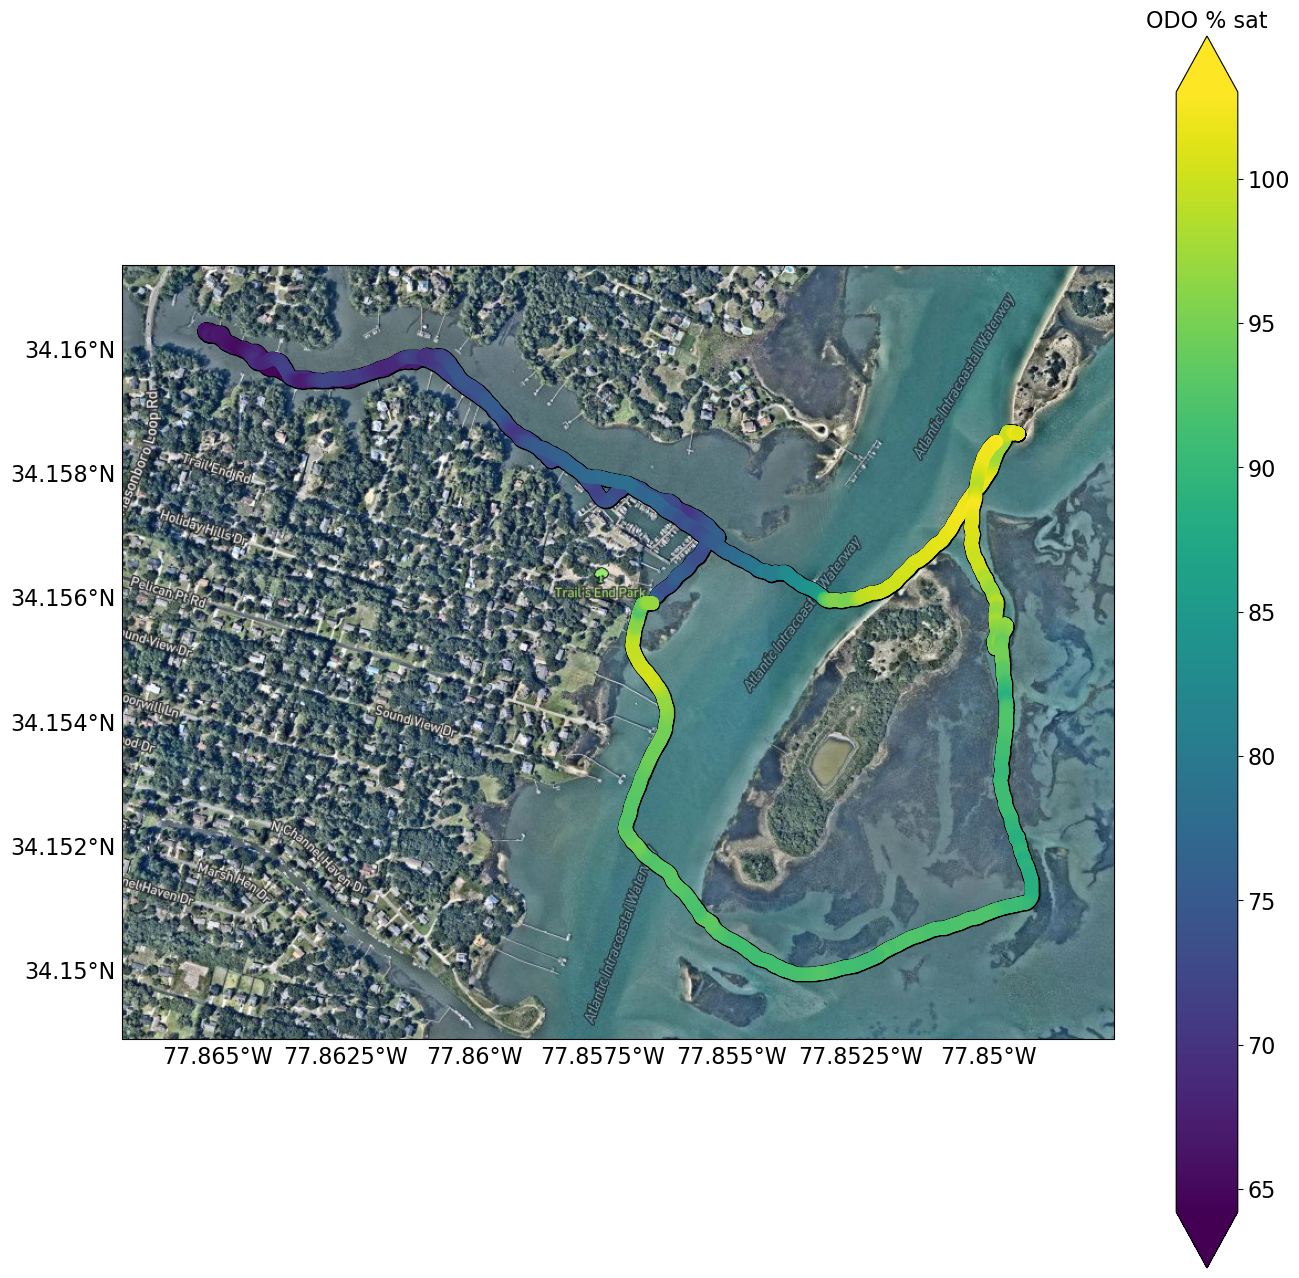

In [27]:
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

# plt.savefig(fname + var_name+'.png', dpi = 300) # (un)comment depending on preference for saving figure locally